In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
from google.cloud import bigquery

client = bigquery.Client(project="trelis-arc")

table_name = "trelis-arc.arc.partially_correct_100"
file_name = table_name.split('.')[-1]

/home/lewis/code/trelis-arc/.venv/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
create_final_table_query = f"""
CREATE OR REPLACE TABLE `{table_name}` AS

WITH arc_2_eval_tasks AS (
    SELECT DISTINCT task_id
    FROM `trelis-arc.arc.arc_task_ids`
    WHERE subset = "arc-agi-2/evaluation"
),
-- Clean programs by collapsing multiple empty lines into single empty lines
programs_cleaned AS (
    SELECT 
        k.task_id,
        -- Clean code by collapsing multiple consecutive newlines into at most one empty line
        -- Pattern matches multiple consecutive newlines with optional whitespace
        REGEXP_REPLACE(k.code, r'\\n(\\s*\\n)+', '\\n\\n') as code,
        k.model,
        k.predicted_train_output,
        k.predicted_test_output,
        k.correct_train_input,
        k.correct_test_input
    FROM `trelis-arc.arc.superking` k
    WHERE task_id NOT IN (SELECT task_id FROM arc_2_eval_tasks)
),
-- Calculate metrics and filter by grid size
programs_with_metrics AS (
    SELECT 
        task_id,
        code,
        model,
        predicted_train_output,
        predicted_test_output,
        correct_train_input,
        correct_test_input,
        LENGTH(code) as program_length,
        -- Check if all train inputs are correct
        (SELECT LOGICAL_AND(correct_val.element) 
         FROM UNNEST(correct_train_input.list) AS correct_val) as all_train_correct,
        -- Check if all test inputs are correct
        (SELECT LOGICAL_AND(correct_val.element) 
         FROM UNNEST(correct_test_input.list) AS correct_val) as all_test_correct,
        -- Count correct examples
        (SELECT COUNTIF(correct_val.element) 
         FROM UNNEST(correct_train_input.list) AS correct_val) + 
        (SELECT COUNTIF(correct_val.element) 
         FROM UNNEST(correct_test_input.list) AS correct_val) as total_correct,
        ARRAY_LENGTH(correct_train_input.list) + ARRAY_LENGTH(correct_test_input.list) as total_possible,
        -- Check grid sizes for train output
        (SELECT MAX(ARRAY_LENGTH(grid_2d.element.list)) 
         FROM UNNEST(predicted_train_output.list) AS grid_2d) as max_train_grid_height,
        (SELECT MAX(ARRAY_LENGTH(row_1d.element.list)) 
         FROM UNNEST(predicted_train_output.list) AS grid_2d,
              UNNEST(grid_2d.element.list) AS row_1d) as max_train_grid_width,
        -- Check grid sizes for test output
        (SELECT MAX(ARRAY_LENGTH(grid_2d.element.list)) 
         FROM UNNEST(predicted_test_output.list) AS grid_2d) as max_test_grid_height,
        (SELECT MAX(ARRAY_LENGTH(row_1d.element.list)) 
         FROM UNNEST(predicted_test_output.list) AS grid_2d,
              UNNEST(grid_2d.element.list) AS row_1d) as max_test_grid_width,
        -- Normalize code for deduplication (remove all whitespace, lowercase)
        LOWER(REGEXP_REPLACE(code, r'\\s+', '')) as normalized_code
    FROM programs_cleaned
),
-- Filter by grid size (40x40) and require at least one correct
programs_filtered AS (
    SELECT *,
        -- Calculate success rate for ranking
        SAFE_DIVIDE(total_correct, total_possible) as success_rate
    FROM programs_with_metrics
    WHERE max_train_grid_height <= 40 AND max_train_grid_width <= 40
      AND max_test_grid_height <= 40 AND max_test_grid_width <= 40
      AND total_correct > 0
),
-- Find shortest, most correct program per task
task_benchmarks AS (
    SELECT 
        task_id,
        MIN(program_length) as shortest_best_length
    FROM (
        SELECT 
            task_id,
            program_length,
            ROW_NUMBER() OVER (
                PARTITION BY task_id 
                ORDER BY success_rate DESC, program_length ASC, code ASC
            ) as rank
        FROM programs_filtered
    ) ranked
    WHERE rank = 1
    GROUP BY task_id
),
-- Filter programs to those within 2.5x the shortest best program per task
programs_length_filtered AS (
    SELECT p.*
    FROM programs_filtered p
    INNER JOIN task_benchmarks b ON p.task_id = b.task_id
    WHERE p.program_length <= 2.5 * b.shortest_best_length
),
-- Deduplicate programs (same normalized code + task_id)
programs_deduplicated AS (
    SELECT 
        task_id, code, model, predicted_train_output, predicted_test_output,
        correct_train_input, correct_test_input, program_length, success_rate,
        ROW_NUMBER() OVER (
            PARTITION BY task_id, normalized_code
            ORDER BY success_rate DESC, program_length ASC, model ASC, code ASC
        ) as dedup_rank
    FROM programs_length_filtered
),
-- Take top 500 per task, prioritizing correctness then length
final_selection AS (
    SELECT 
        task_id, code, model, predicted_train_output, predicted_test_output,
        correct_train_input, correct_test_input,
        ROW_NUMBER() OVER (
            PARTITION BY task_id 
            ORDER BY success_rate DESC, program_length ASC, model ASC, code ASC
        ) as final_rank
    FROM programs_deduplicated
    WHERE dedup_rank = 1
)
SELECT task_id, code, model, predicted_train_output, predicted_test_output,
       correct_train_input, correct_test_input
FROM final_selection
WHERE final_rank <= 100
ORDER BY task_id, final_rank
"""

print("Executing BigQuery table creation...")
job = client.query(create_final_table_query)
result = job.result()
print(f"✓ Table `{table_name}` created successfully")

Executing BigQuery table creation...
✓ Table `trelis-arc.arc.partially_correct_100` created successfully


In [6]:
from llm_python.datasets.bigquery_export import load_bigquery_table_as_dataframe

# Load BigQuery table as DataFrame using our reusable function
print("Loading BigQuery table data...")
raw_data = load_bigquery_table_as_dataframe(
    client=client,
    table_name=table_name
)
print(f"Loaded {len(raw_data)} programs from BigQuery table")

Loading BigQuery table data...
Exporting BigQuery table 'trelis-arc.arc.partially_correct_100' to GCS...
Waiting for BigQuery export to complete...
✓ Export to GCS completed successfully
✓ Download completed
Reading parquet file...
Loaded 50461 rows from BigQuery table
Loaded 50461 programs from BigQuery table


In [7]:
from llm_python.datasets.bigquery_converter import convert_bigquery_to_soar

print("Converting BigQuery data to SOAR format...")
final_dataset = convert_bigquery_to_soar(raw_data, show_progress=True)

Converting BigQuery data to SOAR format...


Converting BQ to SOAR:   0%|          | 0/50461 [00:00<?, ?it/s]

Converting BQ to SOAR: 100%|██████████| 50461/50461 [00:06<00:00, 8212.36it/s] 


Successfully converted 50461 programs from 50461 input rows


In [8]:
from llm_python.datasets.validation import validate_soar_dataframe


validation_result = validate_soar_dataframe(final_dataset)
print(validation_result.summary())
if not validation_result.is_valid:
    raise ValueError("Validation failed: Some programs do not meet the schema requirements.")

Loading arc-prize-2024...
  Training: 400 tasks
  Evaluation: 400 tasks
  Test: 100 tasks
Loading arc-prize-2025...
  Training: 1000 tasks
  Evaluation: 120 tasks
  Test: 240 tasks
Validation results:
    Total programs: 50461
    Rows failing schema validation: 0 [PASS]
    Rows failing data inspection: 0 [PASS]
    Rows failing correctness checks: 0 [PASS]


In [9]:

from llm_python.datasets.io import write_soar_parquet


output_path = f"/tmp/{file_name}.parquet"
print(f"Saving final dataset to: {output_path}")
write_soar_parquet(final_dataset, output_path)

Saving final dataset to: /tmp/partially_correct_100.parquet


DATASET STATISTICS ANALYSIS: partially_correct_100
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 848
   • Total programs: 50,461
   • Fully correct programs: 20,957 (41.5%)
   • Partially correct programs: 29,504 (58.5%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 0.662

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 59.5
   • Median programs per task: 67.5
   • Min programs per task: 1
   • Max programs per task: 100
   • Tasks with 100 programs (max): 355
   • Tasks with fully correct programs: 627
   • Tasks with no correct programs: 221

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1.0
   • 25th percentile: 14.0
   • 50th percentile (median): 67.5
   • 75th percentile: 100.0
   • 90th percentile: 100.0
   • 95th percentile: 100.0
   • 99th percentile: 100.0
   • 100th percentile (max): 100.0

4

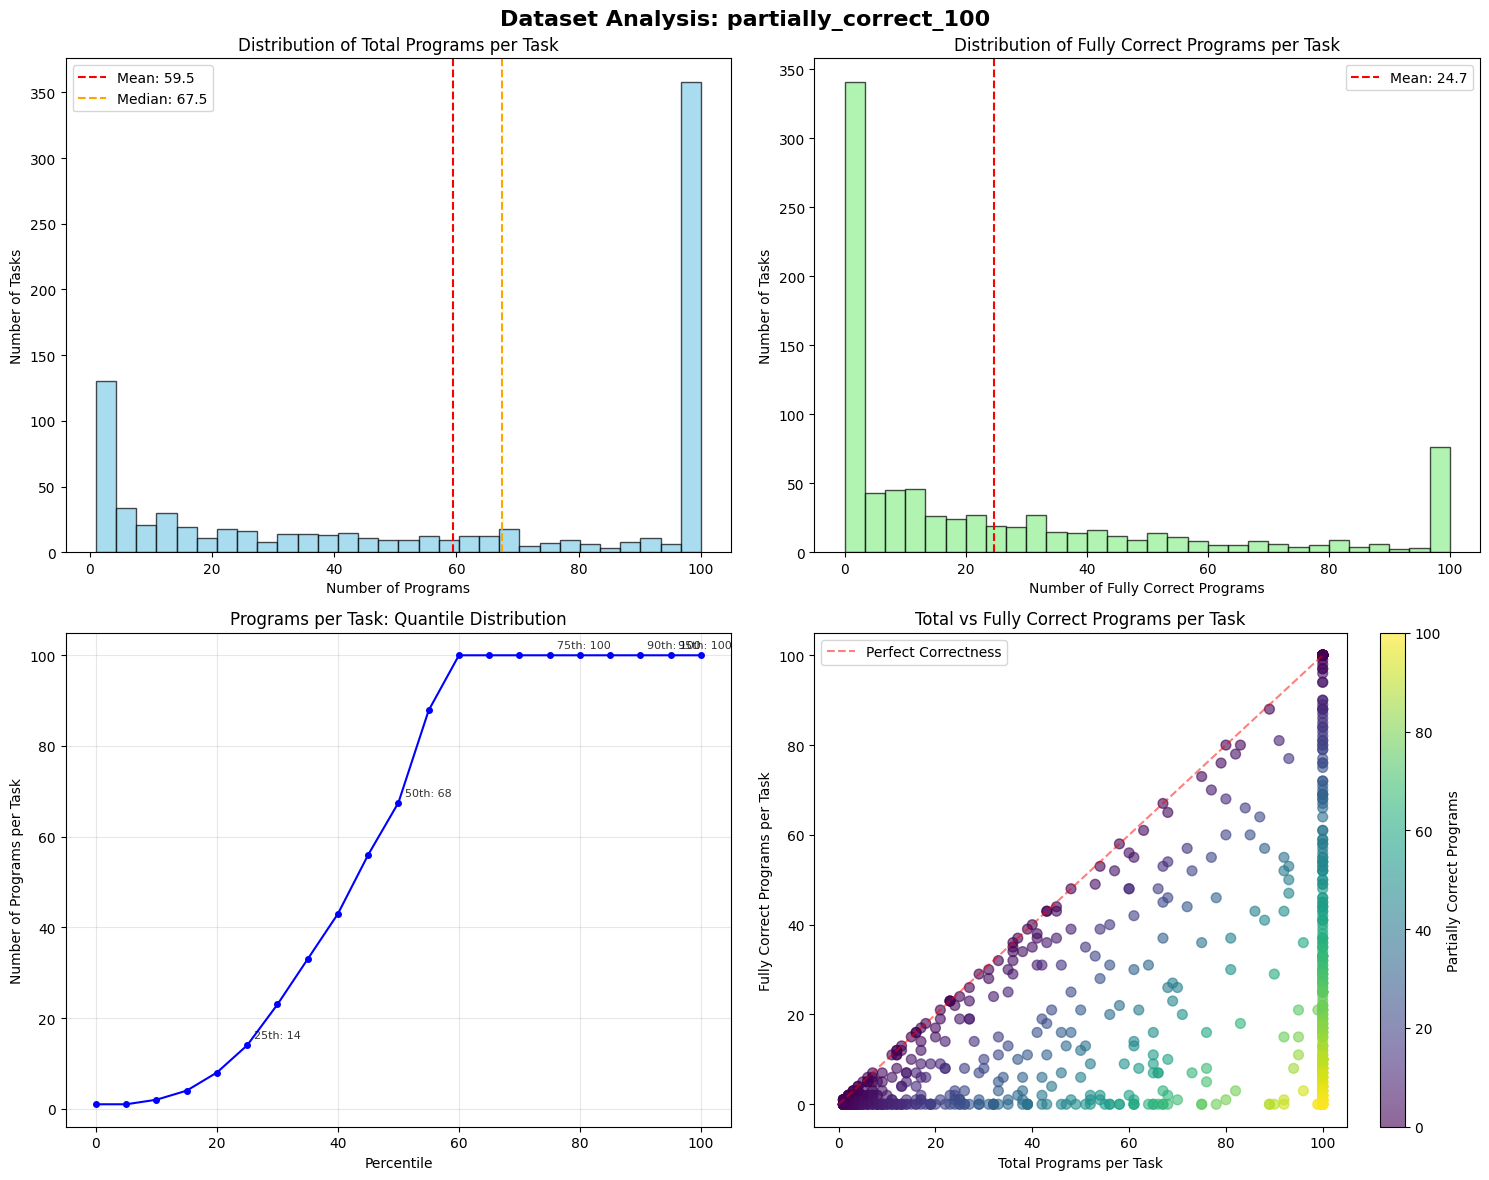


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [10]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(final_dataset, file_name)